In [1]:
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)



Toggle code

In [2]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
plt.style.use('bmh')
import math
import matplotlib
matplotlib.rcParams.update({'font.size': 12, 'font.family': 'Verdana'})

In [3]:
def sim(p = 0.1, time_to_death = 21, time_to_heal = 21, k = 0.08):
    population = 100_000
    days = 200
    death_prob = p
    time_to_death = time_to_death
    time_to_heal = time_to_heal
    hist = [0] # no cases before the storm
    deaths = recovs = naive_cfr = resolved_cfr = 0
    df = pd.DataFrame(index = pd.date_range(start = '15-12-2020', periods = days), \
                      columns = 'day,cases,deaths,recoveries,naive_cfr (%),resolved_cfr (%)'.split(','))
    
    for d in range(1, days):
        cases = round(population / (1 + math.e**(-k*(d - days/2))))
        hist.append(cases)
        
        if d >= time_to_death + 1:
            new_cases_lagged = hist[d - time_to_death] - hist[d - time_to_death - 1]
            new_deaths_lagged = (new_cases_lagged) * death_prob
            deaths += new_deaths_lagged
            
        if d >= time_to_heal + 1:    
            new_cases_lagged = hist[d - time_to_heal] - hist[d - time_to_heal - 1]
            new_recovs_lagged = (new_cases_lagged) * (1 - death_prob)
            recovs += new_recovs_lagged
        
        if d > max(time_to_death, time_to_heal):
            if cases:
                naive_cfr = 100 * deaths / cases
            if deaths + recovs:
                resolved_cfr = 100 * deaths / (deaths + recovs)
                
        df.iloc[d-1] = [d, cases, deaths, recovs, naive_cfr, resolved_cfr]
    return df

_Naive Estimate = Current Deaths / Current Cases_ <br>
_Resolved Estimate = Current Deaths / (Current Deaths + Current Recovered)_

In the following graphs we will see that, __regardless the death probability $p$__, <u> if the death lag is equal to the recovery lag</u>, the naive CFR ratio always underestimates the true CFR, while the resolved CFR is a perfect estimate.

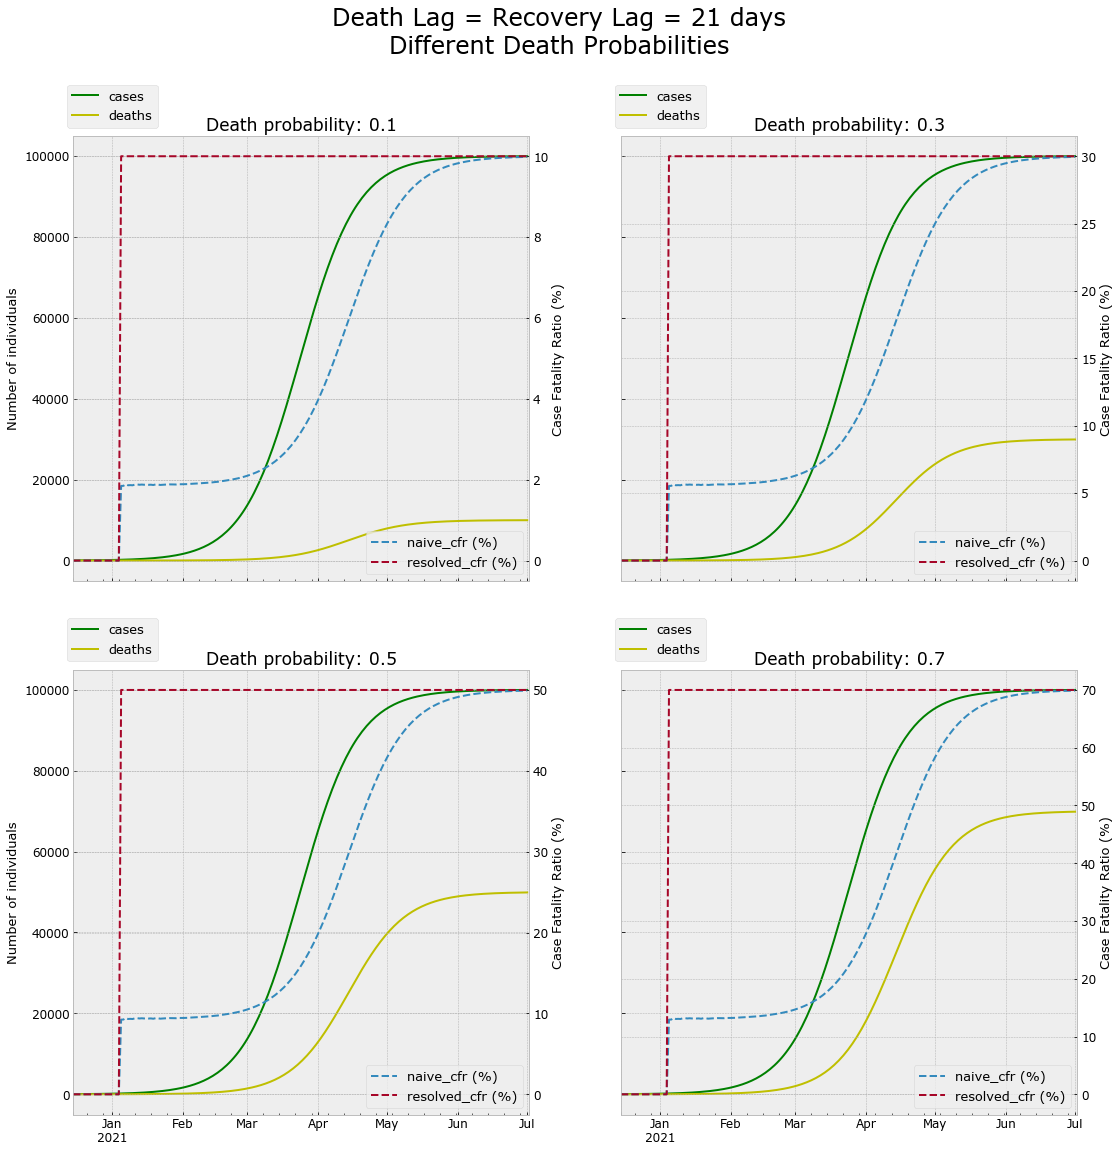

In [4]:
fig, ax = plt.subplots(2,2, sharex=True, sharey=True, figsize = (18,18))
fig.suptitle(f'Death Lag = Recovery Lag = 21 days\nDifferent Death Probabilities', fontsize = 24)
death_probs = [0.1, 0.3, 0.5, 0.7]
j = 0
for i in range(0,2):
    for k in range(0,2):
        df = sim(p = death_probs[j])
        ax1 = ax[i,k].twinx()  
        df[['naive_cfr (%)', 'resolved_cfr (%)']].plot(linestyle = '--', ax = ax1);
        df[['cases','deaths']].plot(ax = ax[i,k], label = ['Cum. Cases', 'Cum. Deaths'], color = ['g','y']);
        ax[i,k].set_title(f'Death probability: {death_probs[j]}')
        ax[i,k].set_ylabel('Number of individuals', fontsize = 13)
        ax1.set_ylabel('Case Fatality Ratio (%)', fontsize = 13)
        ax[i,k].legend(bbox_to_anchor=(0, 0.93, 0.2, 0.2), fontsize = 13)
        ax1.legend(loc = 4, fontsize = 13);    
        j += 1

Now instead we want to hypothesize that:<br>
_death lag $\neq$ recovery lag_

In [5]:
from itertools import product

In [6]:
lag_death = [10,16,21] # list of days before death
lag_recover = [15,20,30] # list of days before recovery

In [7]:
combos = product(lag_death, lag_recover) 

# we want realistically consider only combos in which recovery takes longer than death
combos = [combo for combo in list(combos) if combo[0] < combo[1] ] 
combos

[(10, 15), (10, 20), (10, 30), (16, 20), (16, 30), (21, 30)]

By fixing different lags for death and recovery, with _recovery lag $>$ death lag_ , we find that:

1) If the ratio _recovery lag / death lag_ $<$ 1.5 the Naive CFR underestimation bias is larger than the Resolved CFR overestimation bias. (Fig. (2x2) )

1) If the ratio _recovery lag / death lag_ $\approx$ 1.5 the Naive CFR underestimation has the same bias compared to the Resolved CFR overestimation. (Fig. (1x1))

2) If the ratio _recovery lag / death lag_ $>=$ 2 the Naive CFR underestimation  bias is minor than the Resolved overestimation bias. (Fig. (1x3) and (1x2)) 

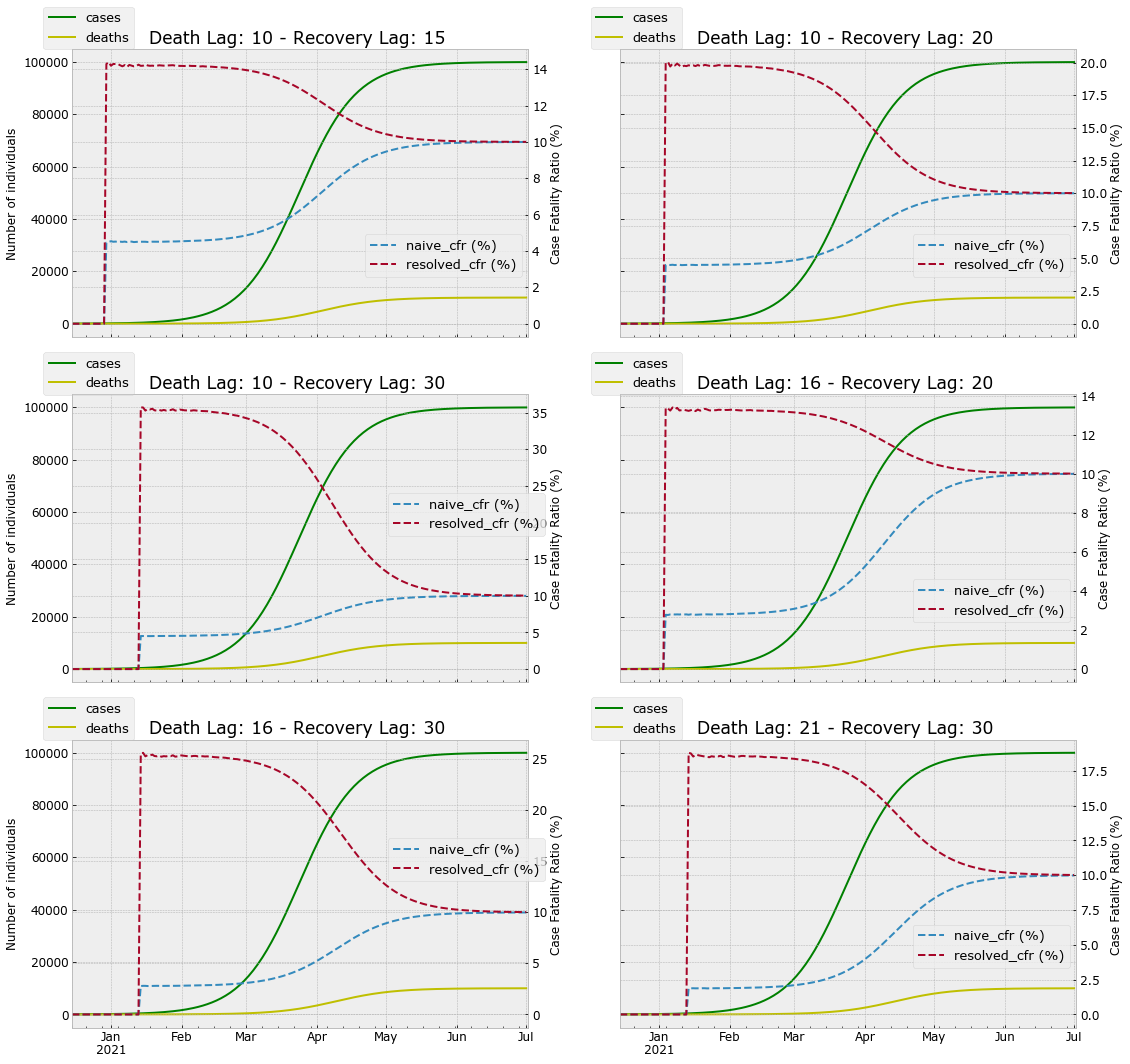

In [8]:
fig, ax = plt.subplots(3,2, sharex=True, sharey=True, figsize = (18,18))

pivot = 0
for i in range(0,3):
    for k in range(0,2):
        df = sim(time_to_death = combos[pivot][0], time_to_heal = combos[pivot][1])
        ax1 = ax[i,k].twinx()  
        df[['naive_cfr (%)', 'resolved_cfr (%)']].plot(linestyle = '--', ax = ax1);
        df[['cases','deaths']].plot(ax = ax[i,k], label = ['Cum. Cases', 'Cum. Deaths'], color = ['g','y']);
        ax[i,k].set_title(f'Death Lag: {combos[pivot][0]} - Recovery Lag: {combos[pivot][1]} ')
        ax[i,k].set_ylabel('Number of individuals', fontsize = 12)
        ax1.set_ylabel('Case Fatality Ratio (%)', fontsize = 12)
        if (i == 1 and k == 0) or (i == 2 and k == 0):
            ax1.legend(bbox_to_anchor=(0.85, 0.33, 0.2, 0.35), fontsize = 13)
        else:
            ax1.legend(bbox_to_anchor=(0.9, 0.03, 0.1, 0.35), fontsize = 13);
        ax[i,k].legend(bbox_to_anchor=(-0.05, 0.97, 0.2, 0.20), fontsize = 13)
        pivot += 1

Reference: [Mark Bevand Blog](http://blog.zorinaq.com/case-fatality-ratio-ncov/)